In [1]:
from radmc3dPy.image import readImage, plotImage, makeImage
from matplotlib import cm
from matplotlib import pyplot as plt
import os
import numpy as np

from astropy import constants as c

au = c.au.cgs.value
pc = c.pc.cgs.value
M_sun = c.M_sun.cgs.value
L_sun = c.L_sun.cgs.value
R_sun = c.R_sun.cgs.value
Grav = c.G.cgs.value
m_p = c.m_p.cgs.value


def logistic(a, r, r0, dr):
    return np.radians(a / (1.0 + np.exp((r - r0) / (0.1 * dr))))


def grid_refine_inner_edge(x_orig, nlev, nspan):
    x = x_orig.copy()
    rev = x[0] > x[1]
    for ilev in range(nlev):
        x_new = 0.5 * (x[1:nspan + 1] + x[:nspan])
        x_ref = np.hstack((x, x_new))
        x_ref.sort()
        x = x_ref
        if rev:
            x = x[::-1]
    return x


def warp_coordinates(x, y, z, phi, theta):
    xprime = x * np.cos(phi) - y * np.sin(phi) * np.cos(theta) + z * np.sin(phi) * np.sin(theta)
    yprime = x * np.sin(phi) + y * np.cos(phi) * np.cos(theta) - z * np.sin(theta) * np.cos(phi)
    zprime = y * np.sin(theta) + z * np.cos(theta)
    return xprime, yprime, zprime


def unwarp_coordinates(x, y, z, phi, theta):
    xprime = x * np.cos(phi) + y * np.sin(phi)
    yprime = -x * np.sin(phi) * np.cos(theta) + y * np.cos(phi) * np.cos(theta) + z * np.sin(theta)
    zprime = x * np.sin(phi) * np.sin(theta) - y * np.sin(theta) * np.cos(phi) + z * np.cos(theta)
    return xprime, yprime, zprime

def vel_sph_to_cart(r, theta, phi, vr, vtheta, vphi):
    
    vx = -r*np.sin(phi)*np.sin(theta)*vphi + r*np.cos(phi)*np.cos(theta)*vtheta + np.sin(theta)*np.cos(phi)*vr
    vy = r*np.sin(phi)*np.cos(theta)*vtheta + r*np.sin(theta)*np.cos(phi)*vphi + np.sin(phi)*np.sin(theta)*vr
    vz = -r*np.sin(theta)*vtheta + np.cos(theta)*vr
    
    return vx, vy, vz

def vel_car_to_sph(x, y, z, vx, vy, vz):
    
    # Velocities
    rho = x**2 + y**2
    r = x**2 + y**2 + z**2 
    
    vr = (x*vx + y*vy + z*vz)/np.sqrt(r)
    vtheta = (-(x*vx + y*vy)*z + (rho)*vz)/(np.sqrt(rho)*(r))
    vphi = (x*vy - y*vx)/(rho)
    return vr, vtheta, vphi

In [2]:
# Monte Carlo parameters
#
nphot_therm = 1000000
nphot_scat = 1000000

In [3]:
# Grid parameters
#
n_r = 200
n_theta = 128
n_phi = 128
r_in = 0.5 * au
r_out = 100 * au
thetaup = 0.1       # Theta grid starting point (0=pole, but singular, so choose >0)

In [4]:
# inner edge grid refinement
nlev_rin = 8
nspan_rin = 3

In [5]:
# Disk parameters
#
sigma_0 = 1e1           # Gas surface density at 1 au [g / cm^2]
d2g = 0.01              # dust-to-gas ratio
gamma_gas = 1.0         # power-law exponent of the surface density
hor_0 = 0.05            # h/r at 1 au
hor_exp = 0.1           # flaring exponent

In [6]:
# Star parameters
#
M_star = 2.4 * M_sun
R_star = 2.4 * R_sun
T_star = 1e4
star_coord = np.array([0., 0., 0.])

In [7]:
# Make the coordinates
#
ri = np.geomspace(r_in, r_out, n_r + 1)
ri = grid_refine_inner_edge(ri, nlev_rin, nspan_rin)   # Refinement at inner edge
thetai = np.linspace(thetaup, np.pi - thetaup, n_theta + 1)
phii = np.linspace(0.0, 2.0 * np.pi, n_phi + 1)
rc = 0.5 * (ri[:-1] + ri[1:])
thetac = 0.5 * (thetai[:-1] + thetai[1:])
phic = 0.5 * (phii[:-1] + phii[1:])
n_r = len(rc)     # Recompute nr, because of refinement at inner edge

In [8]:
# Make the full mesh
#
RC, THETAC, PHIC = np.meshgrid(rc, thetac, phic, indexing='ij')
XC = RC * np.sin(THETAC) * np.cos(PHIC)
YC = RC * np.sin(THETAC) * np.sin(PHIC)
ZC = RC * np.cos(THETAC)

In [9]:
# Warp the coordinates
#
warp = 45. # PA
twist = 45. # This gives the inc

warp_array = logistic(warp, rc, 10 * au, 5 * au)  # Specify the r0 and dr in AU
twist_array = logistic(twist, rc, 10 * au, 5 * au)

XW, YW, ZW = warp_coordinates(
    XC, YC, ZC,
    warp_array[:, None, None],
    twist_array[:, None, None])

RW = np.sqrt(XW**2 + YW**2 + ZW**2)
THETAW = np.pi / 2.0 - np.arctan2(ZW, np.sqrt(XW**2 + YW**2))
PHIW = np.arctan2(YW, XW) + np.pi

In [10]:
# Make the dust density model
#
sig_g = sigma_0 * (RW / au)**-gamma_gas
H = hor_0 * (RW / au)**hor_exp * RW
rho_g = (sig_g / (np.sqrt(2. * np.pi) * H)) * np.exp(-(ZW**2 / H**2) / 2.0)
rho_d = d2g * rho_g

Given the coordinate set, transform into unwarped coordinates, obtain the velocities, transform to cartesian, warp back and transform to spherical.

In [11]:
XU, YU, ZU = unwarp_coordinates(XW, YW, ZW, warp_array[:, None, None], twist_array[:, None, None])

RU = np.sqrt(XU**2 + YU**2 + ZU**2)
THETAU = np.pi / 2.0 - np.arctan2(ZU, np.sqrt(XU**2 + YU**2))
PHIU = np.arctan2(YU, XU) + np.pi

# Make the velocity model in the unwarped coordinates
vr = np.zeros_like(RU)
vtheta = np.zeros_like(RU)
vphi = np.sqrt(Grav * M_star / RU)

vxu, vyu, vzu = vel_sph_to_cart(RU, THETAU, PHIU, vr, vtheta, vphi)
vxw, vyw, vzw = warp_coordinates(vxu, vyu, vzu, warp_array[:, None, None], twist_array[:, None, None])
vr, vtheta, vphi = vel_car_to_sph(XU, YU, ZU, vxu, vyu, vzu)

vturb = 0.001 * vphi

In [12]:
# Write the wavelength_micron.inp file
#
lam1 = 0.1e0
lam2 = 7.0e0
lam3 = 25.0e0
lam4 = 1.0e4
n12 = 20
n23 = 100
n34 = 30
lam12 = np.geomspace(lam1, lam2, n12, endpoint=False)
lam23 = np.geomspace(lam2, lam3, n23, endpoint=False)
lam34 = np.geomspace(lam3, lam4, n34, endpoint=True)
lam = np.concatenate([lam12, lam23, lam34])
nlam = lam.size

In [13]:
# Write the wavelength file
#
with open('wavelength_micron.inp', 'w+') as f:
    f.write('%d\n' % (nlam))
    for value in lam:
        f.write('%13.6e\n' % (value))

In [14]:
# Write the stars.inp file
#
with open('stars.inp', 'w+') as f:
    f.write('2\n')
    f.write('1 %d\n\n' % (nlam))
    f.write('%13.6e %13.6e %13.6e %13.6e %13.6e\n\n' % (R_star, M_star, *star_coord))
    for value in lam:
        f.write('%13.6e\n' % (value))
    f.write('\n%13.6e\n' % (-T_star))

In [15]:
# Write the grid file
#
with open('amr_grid.inp', 'w+') as f:
    f.write('1\n')                       # iformat
    f.write('0\n')                       # AMR grid style  (0=regular grid, no AMR)
    f.write('100\n')                     # Coordinate system: spherical
    f.write('0\n')                       # gridinfo
    f.write('1 1 1\n')                   # Include r,theta coordinates
    f.write('%d %d %d\n' % (n_r, n_theta, n_phi))  # Size of grid
    for value in ri:
        f.write('%13.6e\n' % (value))      # X coordinates (cell walls)
    for value in thetai:
        f.write('%13.6e\n' % (value))      # Y coordinates (cell walls)
    for value in phii:
        f.write('%13.6e\n' % (value))      # Z coordinates (cell walls)

In [16]:
# Write the density file
#
with open('dust_density.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    f.write('1\n')                       # Nr of dust species
    data = rho_d.ravel(order='F')         # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [17]:
# Dust opacity control file
#
with open('dustopac.inp', 'w+') as f:
    f.write('2               Format number of this file\n')
    f.write('1               Nr of dust species\n')
    f.write('============================================================================\n')
    f.write('1               Way in which this dust species is read\n')
    f.write('0               0=Thermal grain\n')
    f.write('silicate        Extension of name of dustkappa_***.inp file\n')
    f.write('----------------------------------------------------------------------------\n')

In [18]:
# Write the molecule number density file.
#
CO_abundance = 1e-4
fact_CO = CO_abundance / (2.3 * m_p)
nco = rho_g * fact_CO
with open('numberdens_co.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    data = nco.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [19]:
# Write the gas velocity field
#
with open('gas_velocity.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    for iphi in range(n_phi):
        for itheta in range(n_theta):
            for ir in range(n_r):
                f.write('%13.6e %13.6e %13.6e\n' % (vr[ir, itheta, iphi], vtheta[ir, itheta, iphi], vphi[ir, itheta, iphi]))

In [20]:
# Write the microturbulence file
#
with open('microturbulence.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    data = vturb.ravel(order='F')        # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [21]:
# Write the lines.inp control file
#
with open('lines.inp', 'w') as f:
    f.write('1\n')
    f.write('1\n')
    f.write('co    leiden    0    0\n')

In [22]:
# Write the radmc3d.inp control file
#
with open('radmc3d.inp', 'w+') as f:
    f.write('nphot = %d\n' % (nphot_therm))
    f.write('nphot_scat = %d\n' % (nphot_scat))
    f.write('scattering_mode_max = 1\n')
    f.write('iranfreqmode = 1\n')
    f.write('tgas_eq_tdust = 1\n')

In [23]:
# Run thermal monte carlo
os.system('radmc3d mctherm setthreads 4')

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http://radmc3d.ita.uni-heidelberg.de/phpbb/          
                                                                 
       

 Thread:           0 Photon nr:                98000
 Thread:           2 Photon nr:                99000
 Thread:           3 Photon nr:               100000
 Thread:           0 Photon nr:               101000
 Thread:           0 Photon nr:               102000
 Thread:           2 Photon nr:               103000
 Thread:           1 Photon nr:               104000
 Thread:           3 Photon nr:               105000
 Thread:           2 Photon nr:               106000
 Thread:           2 Photon nr:               107000
 Thread:           1 Photon nr:               108000
 Thread:           2 Photon nr:               109000
 Thread:           2 Photon nr:               110000
 Thread:           2 Photon nr:               111000
 Thread:           1 Photon nr:               112000
 Thread:           3 Photon nr:               113000
 Thread:           1 Photon nr:               114000
 Thread:           0 Photon nr:               115000
 Thread:           1 Photon nr:               

 Thread:           3 Photon nr:               257000
 Thread:           2 Photon nr:               258000
 Thread:           0 Photon nr:               259000
 Thread:           0 Photon nr:               260000
 Thread:           0 Photon nr:               261000
 Thread:           1 Photon nr:               262000
 Thread:           2 Photon nr:               263000
 Thread:           0 Photon nr:               264000
 Thread:           3 Photon nr:               265000
 Thread:           1 Photon nr:               266000
 Thread:           1 Photon nr:               267000
 Thread:           3 Photon nr:               268000
 Thread:           3 Photon nr:               269000
 Thread:           3 Photon nr:               270000
 Thread:           3 Photon nr:               271000
 Thread:           2 Photon nr:               272000
 Thread:           2 Photon nr:               273000
 Thread:           3 Photon nr:               274000
 Thread:           2 Photon nr:               

 Thread:           3 Photon nr:               415000
 Thread:           1 Photon nr:               416000
 Thread:           2 Photon nr:               417000
 Thread:           2 Photon nr:               418000
 Thread:           3 Photon nr:               419000
 Thread:           3 Photon nr:               420000
 Thread:           1 Photon nr:               421000
 Thread:           0 Photon nr:               422000
 Thread:           2 Photon nr:               423000
 Thread:           3 Photon nr:               424000
 Thread:           2 Photon nr:               425000
 Thread:           2 Photon nr:               426000
 Thread:           2 Photon nr:               427000
 Thread:           2 Photon nr:               428000
 Thread:           1 Photon nr:               429000
 Thread:           3 Photon nr:               430000
 Thread:           3 Photon nr:               431000
 Thread:           0 Photon nr:               432000
 Thread:           0 Photon nr:               

 Thread:           2 Photon nr:               570000
 Thread:           2 Photon nr:               571000
 Thread:           0 Photon nr:               572000
 Thread:           0 Photon nr:               573000
 Thread:           0 Photon nr:               574000
 Thread:           1 Photon nr:               575000
 Thread:           2 Photon nr:               576000
 Thread:           0 Photon nr:               577000
 Thread:           3 Photon nr:               578000
 Thread:           2 Photon nr:               579000
 Thread:           2 Photon nr:               580000
 Thread:           0 Photon nr:               581000
 Thread:           0 Photon nr:               582000
 Thread:           2 Photon nr:               583000
 Thread:           3 Photon nr:               584000
 Thread:           0 Photon nr:               585000
 Thread:           3 Photon nr:               586000
 Thread:           3 Photon nr:               587000
 Thread:           1 Photon nr:               

 Thread:           0 Photon nr:               726000
 Thread:           1 Photon nr:               727000
 Thread:           0 Photon nr:               728000
 Thread:           2 Photon nr:               729000
 Thread:           1 Photon nr:               730000
 Thread:           3 Photon nr:               731000
 Thread:           3 Photon nr:               732000
 Thread:           3 Photon nr:               733000
 Thread:           0 Photon nr:               734000
 Thread:           1 Photon nr:               735000
 Thread:           2 Photon nr:               736000
 Thread:           2 Photon nr:               737000
 Thread:           1 Photon nr:               738000
 Thread:           0 Photon nr:               739000
 Thread:           1 Photon nr:               740000
 Thread:           0 Photon nr:               741000
 Thread:           2 Photon nr:               742000
 Thread:           1 Photon nr:               743000
 Thread:           3 Photon nr:               

 Thread:           0 Photon nr:               882000
 Thread:           0 Photon nr:               883000
 Thread:           1 Photon nr:               884000
 Thread:           1 Photon nr:               885000
 Thread:           3 Photon nr:               886000
 Thread:           3 Photon nr:               887000
 Thread:           2 Photon nr:               888000
 Thread:           1 Photon nr:               889000
 Thread:           1 Photon nr:               890000
 Thread:           3 Photon nr:               891000
 Thread:           1 Photon nr:               892000
 Thread:           0 Photon nr:               893000
 Thread:           3 Photon nr:               894000
 Thread:           0 Photon nr:               895000
 Thread:           0 Photon nr:               896000
 Thread:           1 Photon nr:               897000
 Thread:           0 Photon nr:               898000
 Thread:           3 Photon nr:               899000
 Thread:           3 Photon nr:               

0

In [24]:
# Now let's make a set of channel maps
#
vkms = 0
#command = 'radmc3d image imolspec 1 iline 2 linenlam 20 widthkms 10. theta 45 npix 200'
command = 'radmc3d image imolspec 1 iline 2 vkms {} incl 45 phi 45 npix 200 setthreads 4'.format(vkms)
os.system(command)

  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            http://radmc3d.ita.uni-heidelberg.de/phpbb/          
                                                                 
       

 Thread:           2 Photon nr:                82000
 Thread:           3 Photon nr:                83000
 Thread:           2 Photon nr:                84000
 Thread:           1 Photon nr:                85000
 Thread:           1 Photon nr:                86000
 Thread:           3 Photon nr:                87000
 Thread:           2 Photon nr:                88000
 Thread:           0 Photon nr:                89000
 Thread:           1 Photon nr:                90000
 Thread:           3 Photon nr:                91000
 Thread:           1 Photon nr:                92000
 Thread:           1 Photon nr:                93000
 Thread:           2 Photon nr:                94000
 Thread:           0 Photon nr:                95000
 Thread:           2 Photon nr:                96000
 Thread:           1 Photon nr:                97000
 Thread:           0 Photon nr:                98000
 Thread:           1 Photon nr:                99000
 Thread:           1 Photon nr:               

 Thread:           0 Photon nr:               241000
 Thread:           1 Photon nr:               242000
 Thread:           1 Photon nr:               243000
 Thread:           0 Photon nr:               244000
 Thread:           1 Photon nr:               245000
 Thread:           2 Photon nr:               246000
 Thread:           0 Photon nr:               247000
 Thread:           1 Photon nr:               248000
 Thread:           1 Photon nr:               249000
 Thread:           1 Photon nr:               250000
 Thread:           2 Photon nr:               251000
 Thread:           2 Photon nr:               252000
 Thread:           1 Photon nr:               253000
 Thread:           3 Photon nr:               254000
 Thread:           0 Photon nr:               255000
 Thread:           0 Photon nr:               256000
 Thread:           0 Photon nr:               257000
 Thread:           0 Photon nr:               258000
 Thread:           0 Photon nr:               

 Thread:           1 Photon nr:               401000
 Thread:           2 Photon nr:               402000
 Thread:           0 Photon nr:               403000
 Thread:           3 Photon nr:               404000
 Thread:           1 Photon nr:               405000
 Thread:           0 Photon nr:               406000
 Thread:           2 Photon nr:               407000
 Thread:           3 Photon nr:               408000
 Thread:           1 Photon nr:               409000
 Thread:           3 Photon nr:               410000
 Thread:           2 Photon nr:               411000
 Thread:           2 Photon nr:               412000
 Thread:           3 Photon nr:               413000
 Thread:           1 Photon nr:               414000
 Thread:           2 Photon nr:               415000
 Thread:           2 Photon nr:               416000
 Thread:           3 Photon nr:               417000
 Thread:           0 Photon nr:               418000
 Thread:           0 Photon nr:               

 Thread:           3 Photon nr:               559000
 Thread:           2 Photon nr:               560000
 Thread:           0 Photon nr:               561000
 Thread:           0 Photon nr:               562000
 Thread:           0 Photon nr:               563000
 Thread:           1 Photon nr:               564000
 Thread:           1 Photon nr:               565000
 Thread:           0 Photon nr:               566000
 Thread:           0 Photon nr:               567000
 Thread:           0 Photon nr:               568000
 Thread:           2 Photon nr:               569000
 Thread:           1 Photon nr:               570000
 Thread:           2 Photon nr:               571000
 Thread:           2 Photon nr:               572000
 Thread:           3 Photon nr:               573000
 Thread:           3 Photon nr:               574000
 Thread:           0 Photon nr:               575000
 Thread:           3 Photon nr:               576000
 Thread:           2 Photon nr:               

 Thread:           1 Photon nr:               714000
 Thread:           2 Photon nr:               715000
 Thread:           1 Photon nr:               716000
 Thread:           2 Photon nr:               717000
 Thread:           0 Photon nr:               718000
 Thread:           0 Photon nr:               719000
 Thread:           0 Photon nr:               720000
 Thread:           0 Photon nr:               721000
 Thread:           3 Photon nr:               722000
 Thread:           0 Photon nr:               723000
 Thread:           3 Photon nr:               724000
 Thread:           1 Photon nr:               725000
 Thread:           3 Photon nr:               726000
 Thread:           1 Photon nr:               727000
 Thread:           2 Photon nr:               728000
 Thread:           1 Photon nr:               729000
 Thread:           0 Photon nr:               730000
 Thread:           2 Photon nr:               731000
 Thread:           3 Photon nr:               

 Thread:           1 Photon nr:               870000
 Thread:           0 Photon nr:               871000
 Thread:           0 Photon nr:               872000
 Thread:           2 Photon nr:               873000
 Thread:           0 Photon nr:               874000
 Thread:           3 Photon nr:               875000
 Thread:           3 Photon nr:               876000
 Thread:           0 Photon nr:               877000
 Thread:           3 Photon nr:               878000
 Thread:           0 Photon nr:               879000
 Thread:           1 Photon nr:               880000
 Thread:           3 Photon nr:               881000
 Thread:           1 Photon nr:               882000
 Thread:           3 Photon nr:               883000
 Thread:           3 Photon nr:               884000
 Thread:           1 Photon nr:               885000
 Thread:           2 Photon nr:               886000
 Thread:           3 Photon nr:               887000
 Thread:           3 Photon nr:               

0

Reading image.out


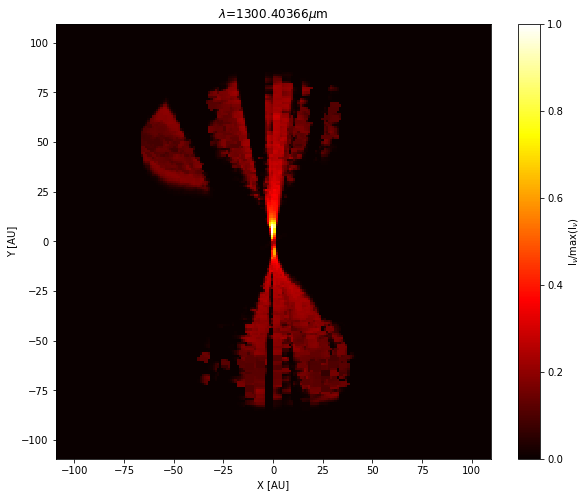

{'implot': <matplotlib.image.AxesImage at 0x7fc3d3cd98e0>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fc3cc4615e0>}

In [25]:
# Read the image
#
im = readImage()
# plotImage(im,ifreq=18,au=True,cmap=cm.hot)
f, ax = plt.subplots(figsize=(10, 8))
plotImage(im, au=True, cmap=cm.hot, ax=ax)

In [26]:

dpc = 140.     # Distance in parsec (for conversion to Jy/pixel in 1.3 mm map)
incl = 45.
phi = 45.

In [27]:
# Make and plot image of full disk at 1.3 mm: thermal dust emission
#
makeImage(npix=400, incl=incl, phi=phi, wav=1.3e3, sizeau=200)  # , setthreads=4)   # This calls radmc3d

Executing RADMC-3D Command:
radmc3d image npix 400 incl 45.0 sizeau 200 lambda 1300.0 phi 45.0 pointau 0.0  0.0  0.0 fluxcons
  
      WELCOME TO RADMC-3D: A 3-D CONTINUUM AND LINE RT SOLVER    
                                                                 
                          VERSION 2.0                            
                                                                 
                (c) 2008-2020 Cornelis Dullemond                 
                                                                 
       Please feel free to ask questions. Also please report     
        bugs and/or suspicious behavior without hestitation.     
      The reliability of this code depends on your vigilance!    
                    dullemond@uni-heidelberg.de                  
                                                                 
   To keep up-to-date with bug-alarms and bugfixes, register to  
                     the RADMC-3D forum:                         
            h

 Thread:           0 Photon nr:                84000
 Thread:           0 Photon nr:                85000
 Thread:           0 Photon nr:                86000
 Thread:           0 Photon nr:                87000
 Thread:           0 Photon nr:                88000
 Thread:           0 Photon nr:                89000
 Thread:           0 Photon nr:                90000
 Thread:           0 Photon nr:                91000
 Thread:           0 Photon nr:                92000
 Thread:           0 Photon nr:                93000
 Thread:           0 Photon nr:                94000
 Thread:           0 Photon nr:                95000
 Thread:           0 Photon nr:                96000
 Thread:           0 Photon nr:                97000
 Thread:           0 Photon nr:                98000
 Thread:           0 Photon nr:                99000
 Thread:           0 Photon nr:               100000
 Thread:           0 Photon nr:               101000
 Thread:           0 Photon nr:               

 Thread:           0 Photon nr:               240000
 Thread:           0 Photon nr:               241000
 Thread:           0 Photon nr:               242000
 Thread:           0 Photon nr:               243000
 Thread:           0 Photon nr:               244000
 Thread:           0 Photon nr:               245000
 Thread:           0 Photon nr:               246000
 Thread:           0 Photon nr:               247000
 Thread:           0 Photon nr:               248000
 Thread:           0 Photon nr:               249000
 Thread:           0 Photon nr:               250000
 Thread:           0 Photon nr:               251000
 Thread:           0 Photon nr:               252000
 Thread:           0 Photon nr:               253000
 Thread:           0 Photon nr:               254000
 Thread:           0 Photon nr:               255000
 Thread:           0 Photon nr:               256000
 Thread:           0 Photon nr:               257000
 Thread:           0 Photon nr:               

 Thread:           0 Photon nr:               395000
 Thread:           0 Photon nr:               396000
 Thread:           0 Photon nr:               397000
 Thread:           0 Photon nr:               398000
 Thread:           0 Photon nr:               399000
 Thread:           0 Photon nr:               400000
 Thread:           0 Photon nr:               401000
 Thread:           0 Photon nr:               402000
 Thread:           0 Photon nr:               403000
 Thread:           0 Photon nr:               404000
 Thread:           0 Photon nr:               405000
 Thread:           0 Photon nr:               406000
 Thread:           0 Photon nr:               407000
 Thread:           0 Photon nr:               408000
 Thread:           0 Photon nr:               409000
 Thread:           0 Photon nr:               410000
 Thread:           0 Photon nr:               411000
 Thread:           0 Photon nr:               412000
 Thread:           0 Photon nr:               

 Thread:           0 Photon nr:               551000
 Thread:           0 Photon nr:               552000
 Thread:           0 Photon nr:               553000
 Thread:           0 Photon nr:               554000
 Thread:           0 Photon nr:               555000
 Thread:           0 Photon nr:               556000
 Thread:           0 Photon nr:               557000
 Thread:           0 Photon nr:               558000
 Thread:           0 Photon nr:               559000
 Thread:           0 Photon nr:               560000
 Thread:           0 Photon nr:               561000
 Thread:           0 Photon nr:               562000
 Thread:           0 Photon nr:               563000
 Thread:           0 Photon nr:               564000
 Thread:           0 Photon nr:               565000
 Thread:           0 Photon nr:               566000
 Thread:           0 Photon nr:               567000
 Thread:           0 Photon nr:               568000
 Thread:           0 Photon nr:               

 Thread:           0 Photon nr:               707000
 Thread:           0 Photon nr:               708000
 Thread:           0 Photon nr:               709000
 Thread:           0 Photon nr:               710000
 Thread:           0 Photon nr:               711000
 Thread:           0 Photon nr:               712000
 Thread:           0 Photon nr:               713000
 Thread:           0 Photon nr:               714000
 Thread:           0 Photon nr:               715000
 Thread:           0 Photon nr:               716000
 Thread:           0 Photon nr:               717000
 Thread:           0 Photon nr:               718000
 Thread:           0 Photon nr:               719000
 Thread:           0 Photon nr:               720000
 Thread:           0 Photon nr:               721000
 Thread:           0 Photon nr:               722000
 Thread:           0 Photon nr:               723000
 Thread:           0 Photon nr:               724000
 Thread:           0 Photon nr:               

 Thread:           0 Photon nr:               863000
 Thread:           0 Photon nr:               864000
 Thread:           0 Photon nr:               865000
 Thread:           0 Photon nr:               866000
 Thread:           0 Photon nr:               867000
 Thread:           0 Photon nr:               868000
 Thread:           0 Photon nr:               869000
 Thread:           0 Photon nr:               870000
 Thread:           0 Photon nr:               871000
 Thread:           0 Photon nr:               872000
 Thread:           0 Photon nr:               873000
 Thread:           0 Photon nr:               874000
 Thread:           0 Photon nr:               875000
 Thread:           0 Photon nr:               876000
 Thread:           0 Photon nr:               877000
 Thread:           0 Photon nr:               878000
 Thread:           0 Photon nr:               879000
 Thread:           0 Photon nr:               880000
 Thread:           0 Photon nr:               

0

Reading image.out


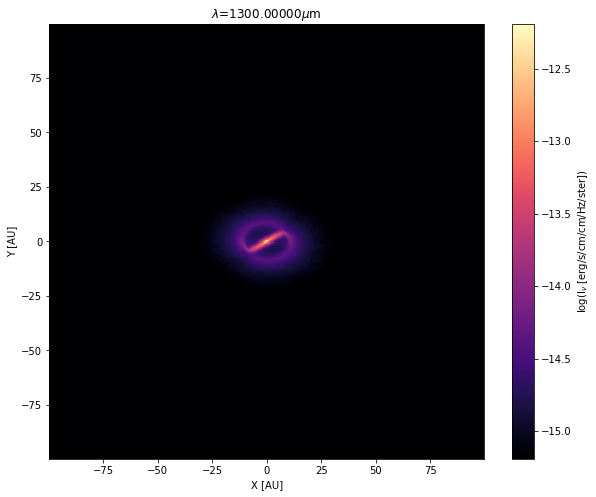

{'implot': <matplotlib.image.AxesImage at 0x7fc3cc2361f0>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7fc3cc258d60>}

In [28]:
im_mm = readImage()
f, ax = plt.subplots(figsize=(10, 8))
plotImage(im_mm, au=True, log=True, maxlog=3, bunit='inu', dpc=dpc, cmap='magma', ax=ax)